In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

import os
import sys
import numpy as np
import seaborn as sb

import tensorflow as tf 
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn .metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn .model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn .metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Bidirectional
 

In [49]:
stock_data = pd.read_csv(r'C:\Users\MY\Documents\Python Scripts\stockdata.csv')
stock_data .head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0,1
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0,1
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0,1
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0,1
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0,1


In [50]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       1258 non-null   object 
 1   date         1258 non-null   object 
 2   close        1258 non-null   float64
 3   high         1258 non-null   float64
 4   low          1258 non-null   float64
 5   open         1258 non-null   float64
 6   volume       1258 non-null   int64  
 7   adjClose     1258 non-null   float64
 8   adjHigh      1258 non-null   float64
 9   adjLow       1258 non-null   float64
 10  adjOpen      1258 non-null   float64
 11  adjVolume    1258 non-null   int64  
 12  divCash      1258 non-null   int64  
 13  splitFactor  1258 non-null   int64  
dtypes: float64(8), int64(4), object(2)
memory usage: 137.7+ KB


In [51]:
stock_data = stock_data[ ['date','open','close'] ] 
stock_data['date'] = pd.to_datetime(stock_data ['date'].apply(lambda x: x.split()[0])) 
stock_data.set_index('date',drop=True,inplace=True) 
stock_data.head()

,open,close
date,,
2016-06-14,716.48,718.27
2016-06-15,719.00,718.92
2016-06-16,714.91,710.36
2016-06-17,708.65,691.72
2016-06-20,698.77,693.71


C:\Users\MY\AppData\Local\Temp\ipykernel_100\2297659235.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fg.show()


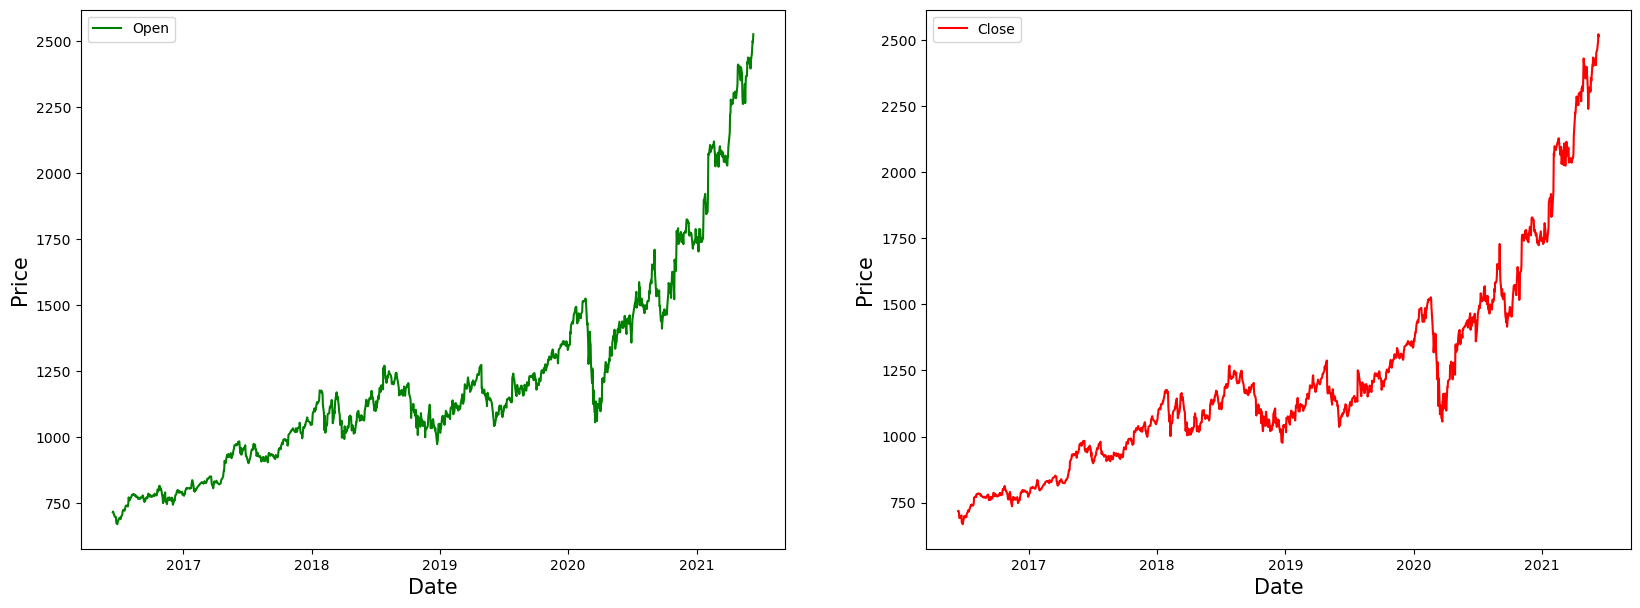

In [52]:
fg, ax =plt.subplots(1,2,figsize=(20,7))
ax[0].plot(stock_data['open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=15)
ax[0].set_ylabel('Price',size=15)
ax[0].legend()

ax[1].plot(stock_data['close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=15)
ax[1].set_ylabel('Price',size=15)
ax[1].legend()

fg.show()

In [53]:
Ms = MinMaxScaler()
stock_data [stock_data .columns] = Ms.fit_transform(stock_data )
stock_data.shape


(1258, 2)

In [54]:
training_size = round(len(stock_data) * 0.80) # Selecting 80 % for training and 20 % for testing
training_size

1006

In [55]:
train_data = stock_data[:training_size]
test_data  = stock_data[training_size:]

train_data.shape, test_data.shape

((1006, 2), (252, 2))

In [56]:
# Function to create sequence of data for training and testing

def create_sequence(dataset):
  sequences = []
  labels = []

  start_idx = 0

  for stop_idx in range(50,len(dataset)):
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences),np.array(labels))

In [57]:
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)
train_seq.shape, train_label.shape, test_seq.shape, test_label.shape

((956, 50, 2), (956, 2), (202, 50, 2), (202, 2))

In [58]:
# Creating LSTM 

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1)) 
model.add(LSTM(units=50))

model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10600     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 30,902
Trainable params: 30,902
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.fit(train_seq, train_label, epochs=20,validation_data=(test_seq, test_label), verbose=1)

Epoch 1/20
30/30 [==============================] - 3s 115ms/step - loss: 1.2267e-04 - mean_absolute_error: 0.0078 - val_loss: 0.0039 - val_mean_absolute_error: 0.0485
Epoch 2/20
30/30 [==============================] - 3s 100ms/step - loss: 1.2381e-04 - mean_absolute_error: 0.0078 - val_loss: 0.0035 - val_mean_absolute_error: 0.0468
Epoch 3/20
30/30 [==============================] - 3s 101ms/step - loss: 1.2600e-04 - mean_absolute_error: 0.0080 - val_loss: 0.0028 - val_mean_absolute_error: 0.0410
Epoch 4/20
30/30 [==============================] - 3s 88ms/step - loss: 1.2680e-04 - mean_absolute_error: 0.0081 - val_loss: 0.0021 - val_mean_absolute_error: 0.0345
Epoch 5/20
30/30 [==============================] - 3s 100ms/step - loss: 1.1982e-04 - mean_absolute_error: 0.0078 - val_loss: 0.0027 - val_mean_absolute_error: 0.0391
Epoch 6/20
30/30 [==============================] - 3s 87ms/step - loss: 1.2194e-04 - mean_absolute_error: 0.0078 - val_loss: 0.0019 - val_mean_absolute_error: 0

In [64]:
test_predicted = model.predict(test_seq)
test_predicted[:5]

7/7 [==============================] - 0s 37ms/step


array([[0.48457447, 0.48848796],
       [0.49074528, 0.49449873],
       [0.49543068, 0.4991145 ],
       [0.51450366, 0.5181269 ],
       [0.52405286, 0.52729666]], dtype=float32)

In [66]:
test_inverse_predicted = Ms.inverse_transform(test_predicted) # Inversing scaling on predicted data
test_inverse_predicted[:5]

array([[1569.3623, 1573.5944],
       [1580.8025, 1584.7344],
       [1589.4888, 1593.289 ],
       [1624.8486, 1628.5254],
       [1642.5521, 1645.52  ]], dtype=float32)

In [67]:
# Merging actual and predicted data for better visualization

gs_slic_data = pd.concat([stock_data.iloc[-202:].copy(),pd.DataFrame(test_inverse_predicted,columns=['open_predicted','close_predicted'],index=stock_data.iloc[-202:].index)], axis=1)

In [69]:
gs_slic_data[['open','close']] = Ms.inverse_transform(gs_slic_data[['open','close']]) # Inverse scaling
gs_slic_data.head()

,open,close,open_predicted,close_predicted
date,,,,
2020-08-24,2.955782e+06,2.944143e+06,1569.362305,1573.594360
2020-08-25,2.933702e+06,2.981247e+06,1580.802490,1584.734375
2020-08-26,2.981774e+06,3.063090e+06,1589.488770,1593.288940
2020-08-27,3.066461e+06,3.029637e+06,1624.848633,1628.525391
2020-08-28,3.029031e+06,3.048319e+06,1642.552124,1645.520020


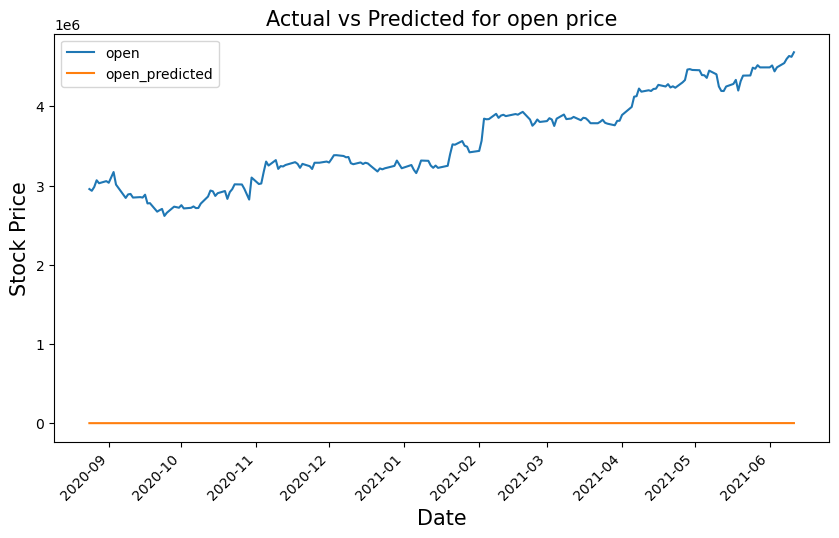

In [70]:
gs_slic_data[['open','open_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()

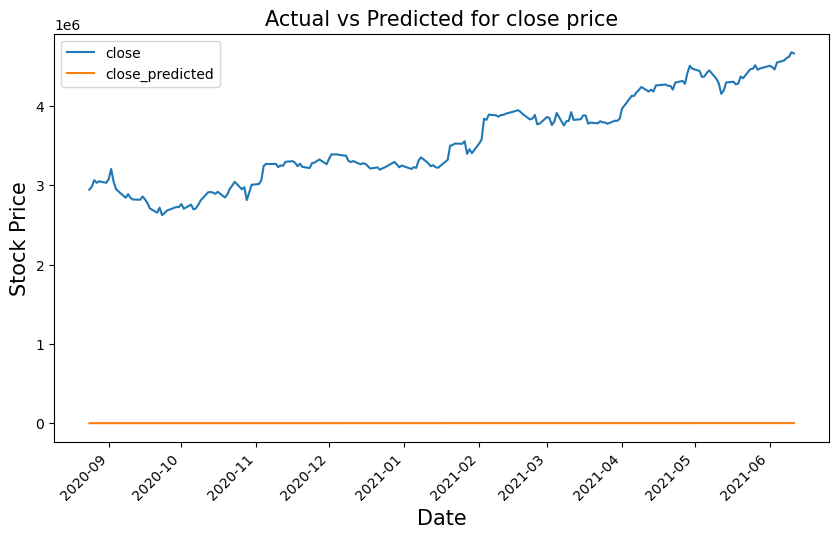

In [71]:
gs_slic_data[['close','close_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()

In [72]:
# Creating a dataframe and adding 10 days to existing index 

gs_slic_data = gs_slic_data.append(pd.DataFrame(columns=gs_slic_data.columns,index=pd.date_range(start=gs_slic_data.index[-1], periods=11, freq='D', closed='right')))

gs_slic_data['2021-06-09	':'2021-06-16']

C:\Users\MY\AppData\Local\Temp\ipykernel_100\2396285801.py:3: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  gs_slic_data = gs_slic_data.append(pd.DataFrame(columns=gs_slic_data.columns,index=pd.date_range(start=gs_slic_data.index[-1], periods=11, freq='D', closed='right')))
C:\Users\MY\AppData\Local\Temp\ipykernel_100\2396285801.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gs_slic_data = gs_slic_data.append(pd.DataFrame(columns=gs_slic_data.columns,index=pd.date_range(start=gs_slic_data.index[-1], periods=11, freq='D', closed='right')))


,open,close,open_predicted,close_predicted
2021-06-09,4.634544e+06,4.618080e+06,2406.866455,2329.147705
2021-06-10,4.624366e+06,4.674050e+06,2406.388672,2324.908691
2021-06-11,4.681671e+06,4.659835e+06,2420.512695,2337.013916
2021-06-12,NaN,NaN,NaN,NaN
2021-06-13,NaN,NaN,NaN,NaN
2021-06-14,NaN,NaN,NaN,NaN
2021-06-15,NaN,NaN,NaN,NaN
2021-06-16,NaN,NaN,NaN,NaN


In [73]:
upcoming_prediction = pd.DataFrame(columns=['open','close'],index=gs_slic_data.index)
upcoming_prediction.index=pd.to_datetime(upcoming_prediction.index)
curr_seq = test_seq[-1:]

for i in range(-10,0):
  up_pred = model.predict(curr_seq)
  upcoming_prediction.iloc[i] = up_pred
  curr_seq = np.append(curr_seq[0][1:],up_pred,axis=0)
  curr_seq = curr_seq.reshape(test_seq[-1:].shape)
upcoming_prediction[['open','close']] = Ms.inverse_transform(upcoming_prediction[['open','close']])

1/1 [==============================] - 0s 47ms/step


C:\Users\MY\AppData\Local\Temp\ipykernel_100\4155468105.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fg.show()


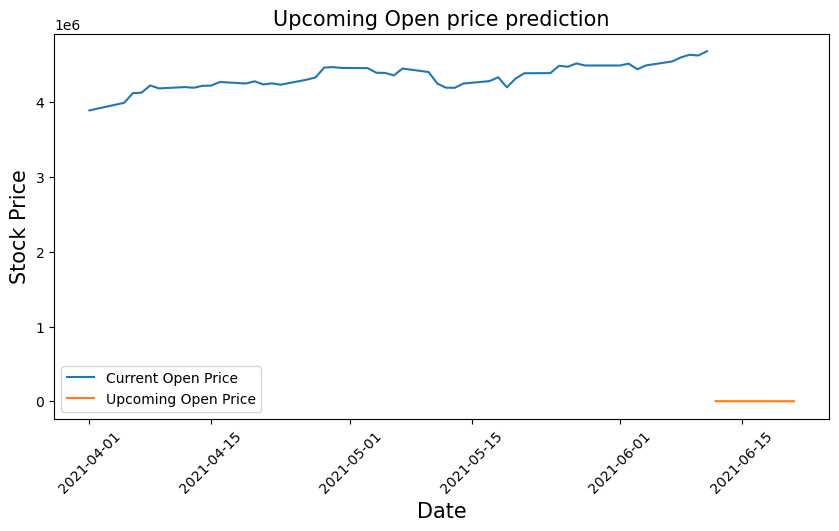

In [74]:
fg,ax=plt.subplots(figsize=(10,5))
ax.plot(gs_slic_data.loc['2021-04-01':,'open'],label='Current Open Price')
ax.plot(upcoming_prediction.loc['2021-04-01':,'open'],label='Upcoming Open Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming Open price prediction',size=15)
ax.legend()
fg.show()

C:\Users\MY\AppData\Local\Temp\ipykernel_100\548185773.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fg.show()


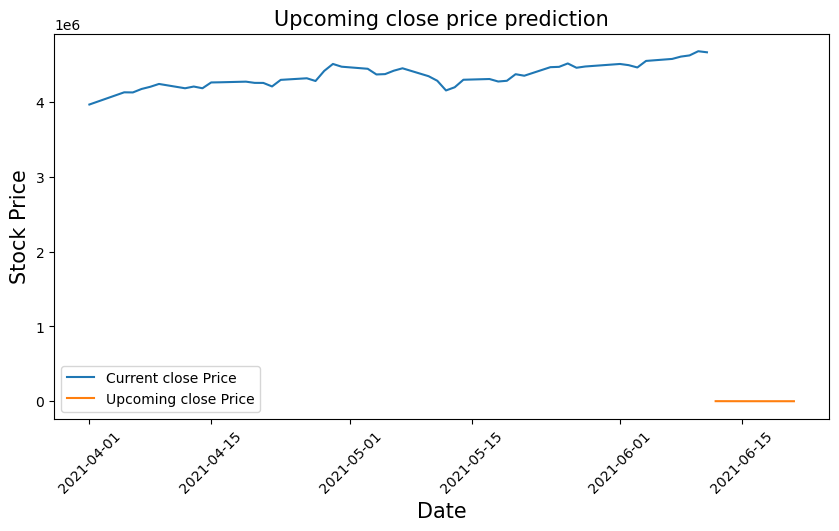

In [75]:
fg,ax=plt.subplots(figsize=(10,5))
ax.plot(gs_slic_data.loc['2021-04-01':,'close'],label='Current close Price')
ax.plot(upcoming_prediction.loc['2021-04-01':,'close'],label='Upcoming close Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming close price prediction',size=15)
ax.legend()
fg.show()